# Training Notebook

# Kaggle Dataset Download



In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

 32% 9.00M/28.4M [00:00<00:00, 88.7MB/s]
100% 28.4M/28.4M [00:00<00:00, 170MB/s] 


In [ ]:
!unzip /content/fruit-images-for-object-detection.zip -d /content/drive/MyDrive/MASOOM_TSadiq/ML1/Fruit_Dataset

# Importing Libraries

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os

# Setting up Directries

In [28]:
test_dir = '/content/drive/MyDrive/MASOOM_TSadiq/ML1/Fruit_Dataset/test_zip/test'
train_dir = '/content/drive/MyDrive/MASOOM_TSadiq/ML1/Fruit_Dataset/train_zip/train'

output_dir = '/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir'

In [29]:
os.makedirs('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/train', exist_ok=True)

#preparing the data by separating labels and images

In [30]:
import shutil

# Define the directories where labels and images will be stored.
label_dir = "/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/train/label"
image_dir = "/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/train/image"

# Create the label and image directories if they don't exist.
os.makedirs(label_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

# Iterate through files in the 'train_dir' directory.
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        # Copy the XML label file to the 'label_dir'.
        shutil.copy(os.path.join(train_dir, file), label_dir)

# Iterate through files in the 'train_dir' directory again.
for filename in os.listdir(train_dir):
    if filename.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, filename))
        # Convert the image to the RGB format (if it's not already).
        image = image.convert("RGB")
        new_filename = os.path.splitext(filename)[0] + ".jpeg"
        image.save(os.path.join(image_dir, new_filename), "JPEG")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [31]:
# Iterate through a list of XML files in the 'train_dir' directory.
for i in glob.glob(train_dir + '/*.xml'):
    # Extract the filename from the file path and remove the '.xml' extension.
    modified_name = i.split('/')[-1][0:-4]

    # Print the modified filename.
    print(modified_name)

    # The 'break' statement exits the loop after processing the first XML file.
    break


apple_1


# Reading XML files in the label_dir and extracting information about object labels, image dimensions, and bounding box coordinates

In [32]:
# Initialize an empty dictionary 'df' with columns for data extraction.
df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
      'xmin': [],
      'ymin': [],
      'xmax': [],
      'ymax': []}

# Iterate through XML files in the 'label_dir' directory.
for idx, anno in enumerate(glob.glob(label_dir + '/*.xml')):
    # Parse the XML file using ElementTree.
    trees = ET.parse(anno)
    root = trees.getroot()

    # Initialize 'width' and 'height' variables.
    width, height = [], []

    # Iterate through elements in the XML.
    for item in root.iter():
        if item.tag == 'size':
            # Extract 'width' and 'height' information.
            for attr in list(item):
                if attr.tag == 'width':
                    width = int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            # Extract 'label' information.
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                # Extract bounding box coordinates.
                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]
                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]


In [33]:
df1 = pd.DataFrame(df)
df1.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,apple_1,apple,0,0,8,15,331,349
1,apple_10,apple,1500,1500,56,99,1413,1419
2,apple_11,apple,652,436,213,33,459,258
3,apple_11,apple,652,436,1,30,188,280
4,apple_11,apple,652,436,116,5,337,220


In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    465 non-null    object
 1   label   465 non-null    object
 2   width   465 non-null    int64 
 3   height  465 non-null    int64 
 4   xmin    465 non-null    int64 
 5   ymin    465 non-null    int64 
 6   xmax    465 non-null    int64 
 7   ymax    465 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 29.2+ KB


In [35]:
df1['label'].unique()

array(['apple', 'banana', 'orange'], dtype=object)

In [36]:
label_map = { 'orange': 0,
            'apple': 1,
            'banana': 2}

df1['class'] = df1['label'].map(label_map)

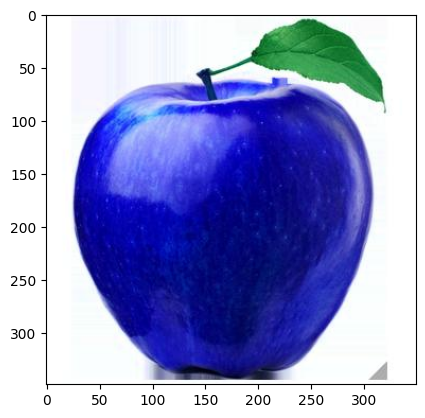

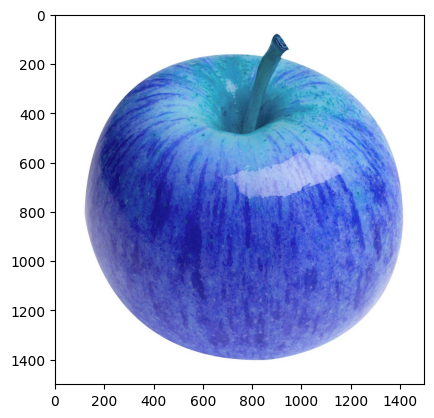

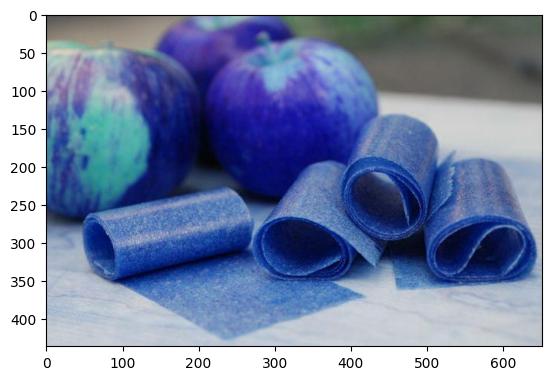

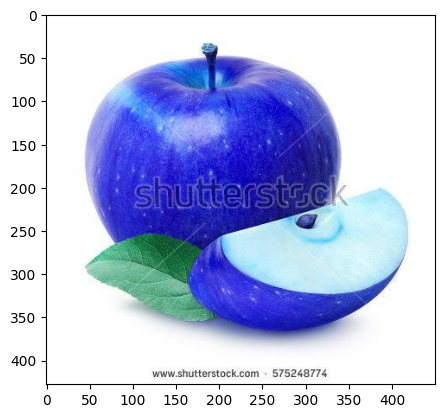

In [37]:
#visualize the sample image
for idx, image in enumerate(os.listdir(image_dir)):
    img = cv2.imread(os.path.join(image_dir, image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

In [38]:
img_file_path = []
for img in os.listdir(image_dir):
    image  = cv2.imread(os.path.join(image_dir, img), 0)
    img_file_path.append(f'{img}')

In [39]:
img_file_path

['apple_1.jpeg',
 'apple_10.jpeg',
 'apple_11.jpeg',
 'apple_12.jpeg',
 'apple_13.jpeg',
 'apple_14.jpeg',
 'apple_15.jpeg',
 'apple_16.jpeg',
 'apple_17.jpeg',
 'apple_18.jpeg',
 'apple_19.jpeg',
 'apple_2.jpeg',
 'apple_20.jpeg',
 'apple_21.jpeg',
 'apple_22.jpeg',
 'apple_23.jpeg',
 'apple_24.jpeg',
 'apple_25.jpeg',
 'apple_26.jpeg',
 'apple_27.jpeg',
 'apple_28.jpeg',
 'apple_29.jpeg',
 'apple_3.jpeg',
 'apple_30.jpeg',
 'apple_31.jpeg',
 'apple_32.jpeg',
 'apple_33.jpeg',
 'apple_35.jpeg',
 'apple_36.jpeg',
 'apple_37.jpeg',
 'apple_38.jpeg',
 'apple_39.jpeg',
 'apple_4.jpeg',
 'apple_40.jpeg',
 'apple_41.jpeg',
 'apple_42.jpeg',
 'apple_43.jpeg',
 'apple_44.jpeg',
 'apple_45.jpeg',
 'apple_46.jpeg',
 'apple_47.jpeg',
 'apple_48.jpeg',
 'apple_49.jpeg',
 'apple_5.jpeg',
 'apple_50.jpeg',
 'apple_51.jpeg',
 'apple_52.jpeg',
 'apple_53.jpeg',
 'apple_54.jpeg',
 'apple_55.jpeg',
 'apple_56.jpeg',
 'apple_57.jpeg',
 'apple_58.jpeg',
 'apple_59.jpeg',
 'apple_6.jpeg',
 'apple_60.jpeg'

In [40]:
import glob

In [41]:
for i in glob.glob(label_dir+'/*.xml'):
    print(i.split('/')[-1][0:-4])
    break

apple_1


In [ ]:
# Split the 'img_file_path' list into 'train' and 'val' subsets.
from sklearn.model_selection import train_test_split
train, val = train_test_split(img_file_path, test_size=0.15, random_state=101)
train, val = train_test_split(img_file_path, test_size=0.15, random_state=101)


# Cloning YOLOv5t

In [43]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15997, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 15997 (delta 19), reused 18 (delta 12), pack-reused 15967
Receiving objects: 100% (15997/15997), 14.64 MiB | 23.58 MiB/s, done.
Resolving deltas: 100% (10981/10981), done.
/content/yolov5/yolov5


In [46]:
ls

train/


# Setting dir for yolo and for labels,images for train and val

In [50]:
#content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/train'
#os.chdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir')
os.mkdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/train')
os.mkdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/val')
os.mkdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/train/images')
os.mkdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/train/labels')
os.mkdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/val/images')
os.mkdir('/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/val/labels')

# Preprocessing Data

In [51]:
def copy_image_file(image_items, folder_name):

    for image in image_items:
        img = Image.open(f'{image_dir}/{image}')
        img1 = img.resize((640, 480))
        _ = img1.save(f'{output_dir}/yolov5/data/{folder_name}/images/{image}')



In [52]:
copy_image_file(train, 'train')
copy_image_file(val, 'val')

In [53]:
df1['xmin'] = (640/df1['width']) * df1['xmin']
df1['ymin'] = (480/df1['height']) * df1['ymin']
df1['xmax'] = (640/df1['width']) * df1['xmax']
df1['ymax'] = (480/df1['height']) * df1['ymax']
df1

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,apple_1,apple,0,0,inf,inf,inf,inf,1
1,apple_10,apple,1500,1500,23.893333,31.680000,602.880000,454.080000,1
2,apple_11,apple,652,436,209.079755,36.330275,450.552147,284.036697,1
3,apple_11,apple,652,436,0.981595,33.027523,184.539877,308.256881,1
4,apple_11,apple,652,436,113.865031,5.504587,330.797546,242.201835,1
...,...,...,...,...,...,...,...,...,...
460,orange_76,orange,1620,1080,195.160494,0.444444,573.629630,329.333333,0
461,orange_76,orange,1620,1080,324.740741,285.777778,640.000000,473.777778,0
462,orange_8,orange,600,393,44.800000,105.038168,300.800000,403.053435,0
463,orange_8,orange,600,393,310.400000,98.931298,581.333333,425.038168,0


In [54]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)
df1

,name,label,width,height,xmin,ymin,xmax,ymax,class
1,apple_10,apple,1500,1500,23.893333,31.680000,602.880000,454.080000,1
2,apple_11,apple,652,436,209.079755,36.330275,450.552147,284.036697,1
3,apple_11,apple,652,436,0.981595,33.027523,184.539877,308.256881,1
4,apple_11,apple,652,436,113.865031,5.504587,330.797546,242.201835,1
5,apple_12,apple,450,428,61.155556,23.551402,497.777778,395.887850,1
...,...,...,...,...,...,...,...,...,...
460,orange_76,orange,1620,1080,195.160494,0.444444,573.629630,329.333333,0
461,orange_76,orange,1620,1080,324.740741,285.777778,640.000000,473.777778,0
462,orange_8,orange,600,393,44.800000,105.038168,300.800000,403.053435,0
463,orange_8,orange,600,393,310.400000,98.931298,581.333333,425.038168,0


In [55]:
df1[['xmin', 'ymin', 'xmax', 'ymax']] = df1[['xmin', 'ymin', 'xmax', 'ymax']].astype('int')

In [56]:
WIDTH = 640
HEIGHT = 480

In [57]:
df1['x_center'] = (df1['xmin']+df1['xmax'])/(2*WIDTH)
df1['y_center'] = (df1['ymin']+df1['ymax'])/(2*HEIGHT)
df1['box_width'] = (df1['xmax']-df1['xmin'])/ WIDTH
df1['box_height'] = (df1['ymax']-df1['ymin'])/ HEIGHT

In [58]:
df1 = df1.astype(str)

In [59]:
def copy_label(label_items, folder_name):
    file_name = [x.split('.')[0] for x in img_file_path]
    for name in file_name:
        data = df1[df1.name == name]

        box_list = []
        for idx in range(len(data)):
            row = data.iloc[idx]
            box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

        text = "\n".join(box_list)
        with open(f'{output_dir}/yolov5/data/{folder_name}/labels/{name}.txt', 'w') as file:
            file.write(text)

In [60]:
copy_label(train, 'train')
copy_label(val, 'val')

# Making data file for our yolo 'yaml file'

In [61]:
yaml_text = """train: /content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/train/images
val: /content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/val/images

nc: 3
names: ['banana', 'apple', 'orange']"""

with open("/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat /content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/data/data.yaml

cat: /content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/data/data.yaml: No such file or directory


# Training Model

In [10]:
!python /content/drive/MyDrive/MASOOM_TSadiq/ML1/yolov5/train.py --img 640 --epochs 50 --batch 16 --data /content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/data.yaml  --weights yolov5s.pt --name fruit_detection_yolov5

train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/MASOOM_TSadiq/ML1/OutPut_Dir/yolov5/data/data.yaml, hyp=drive/.shortcut-targets-by-id/1iozb6gbHu2SRvpv6UzROjoStkWyztaKF/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=drive/.shortcut-targets-by-id/1iozb6gbHu2SRvpv6UzROjoStkWyztaKF/yolov5/runs/train, name=fruit_detection_yolov5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, 

In [ ]:
!python train.py --img 416 --batch 16 --epochs 20 --data /content/drive/MyDrive/ML1_Training/fruits_detection/dataset/data.yaml --weights yolov5s.pt --cache




#!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

# Evaluating the model's performance matrix and grphs

In [11]:
from IPython.display import Image as Display

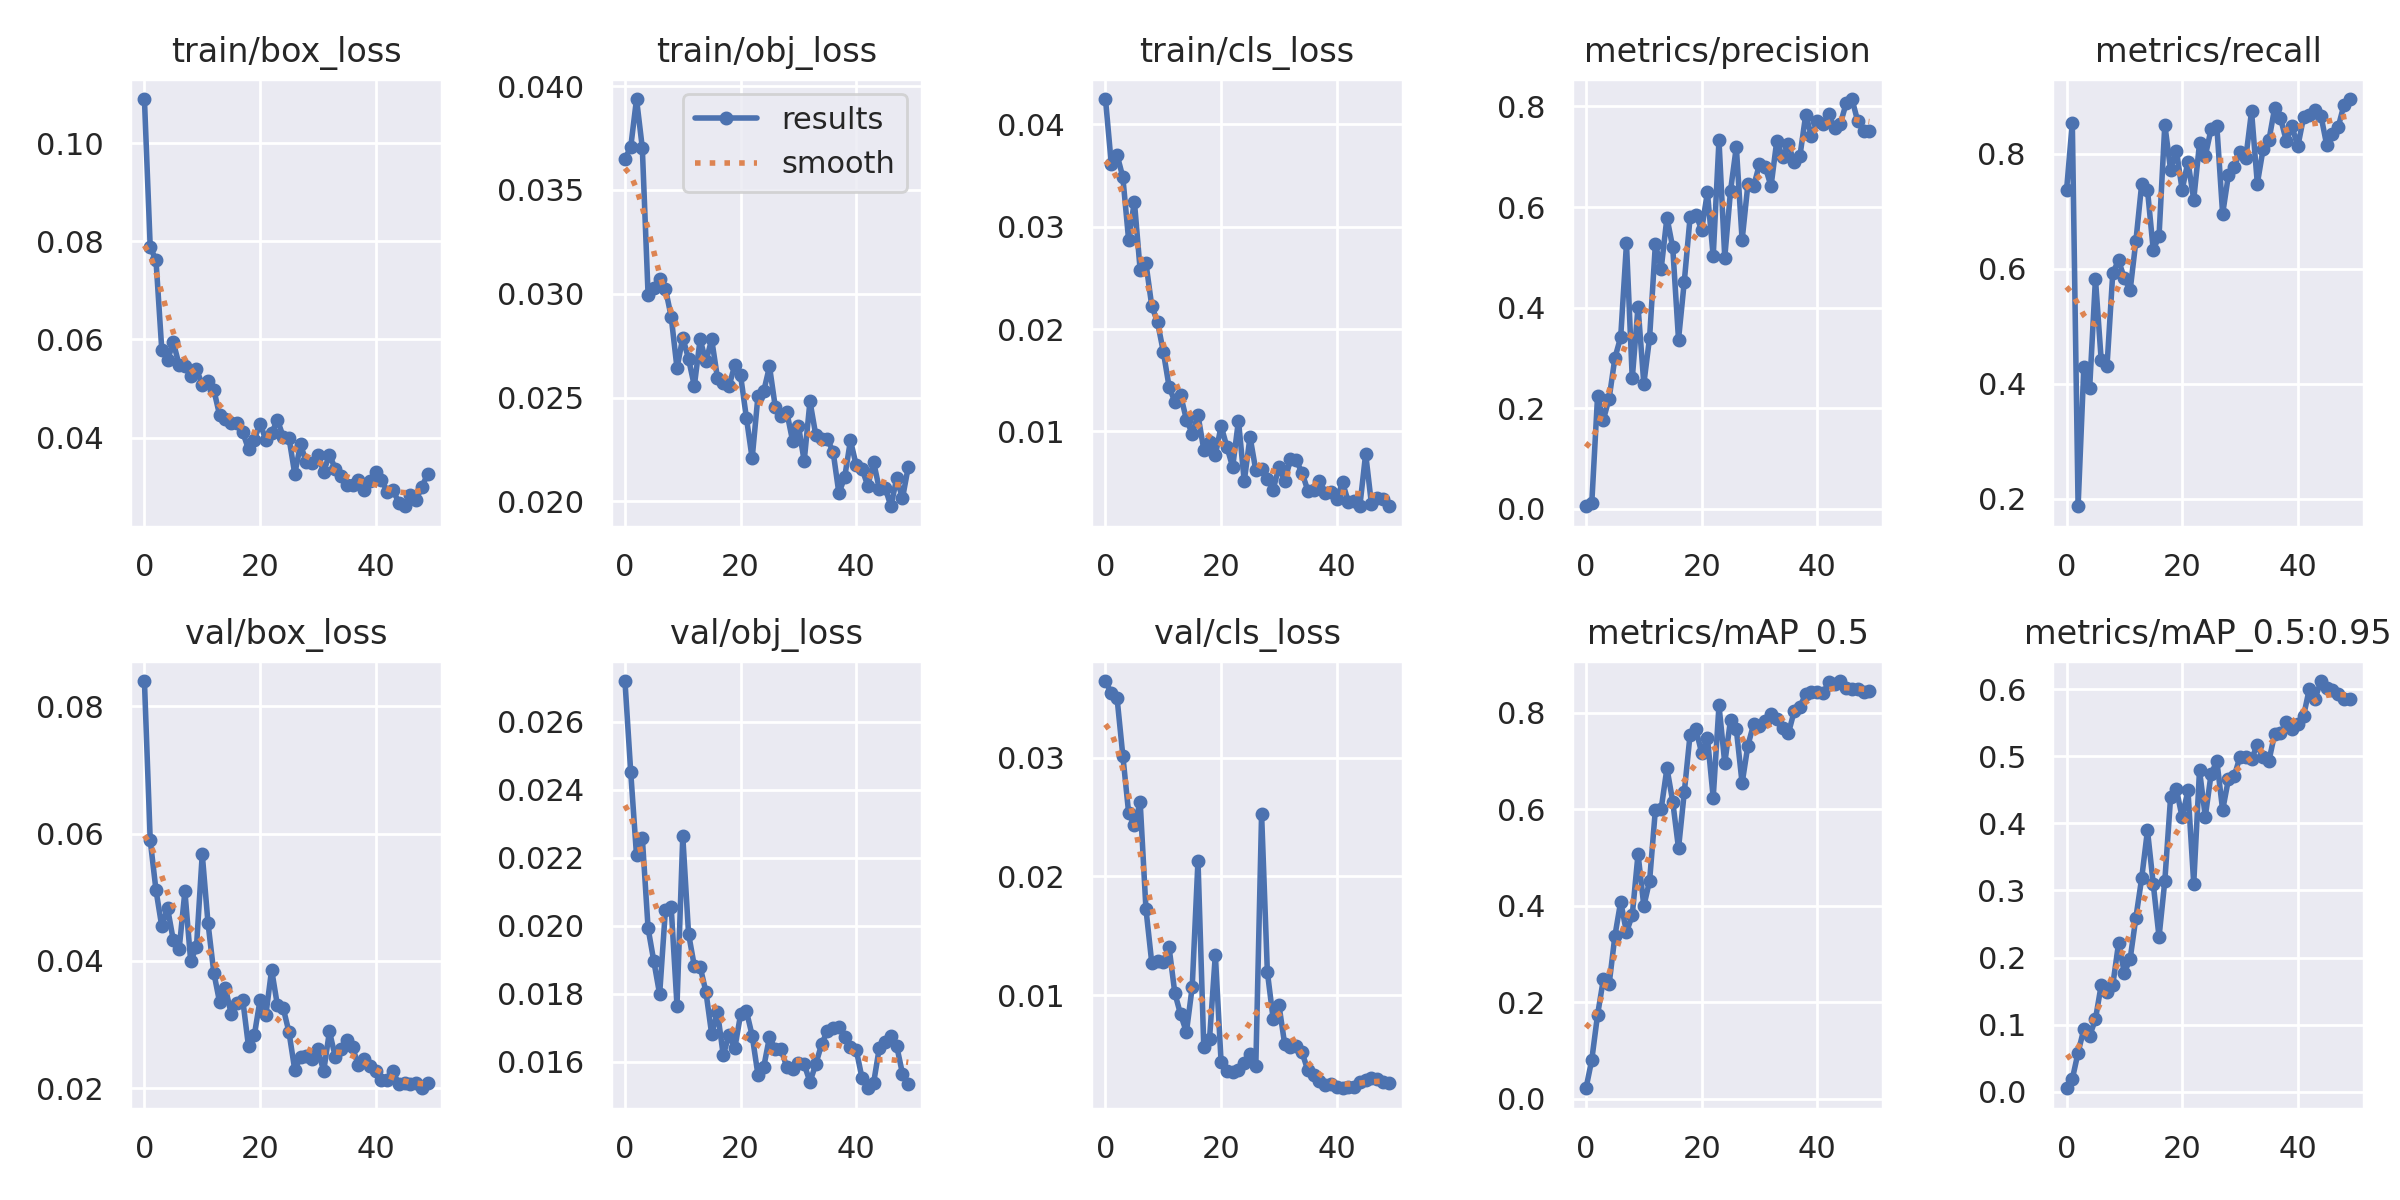

In [12]:
Display(filename='/content/drive/MyDrive/MASOOM_TSadiq/ML1/yolov5/runs/train/fruit_detection_yolov5/results.png', width=1080)

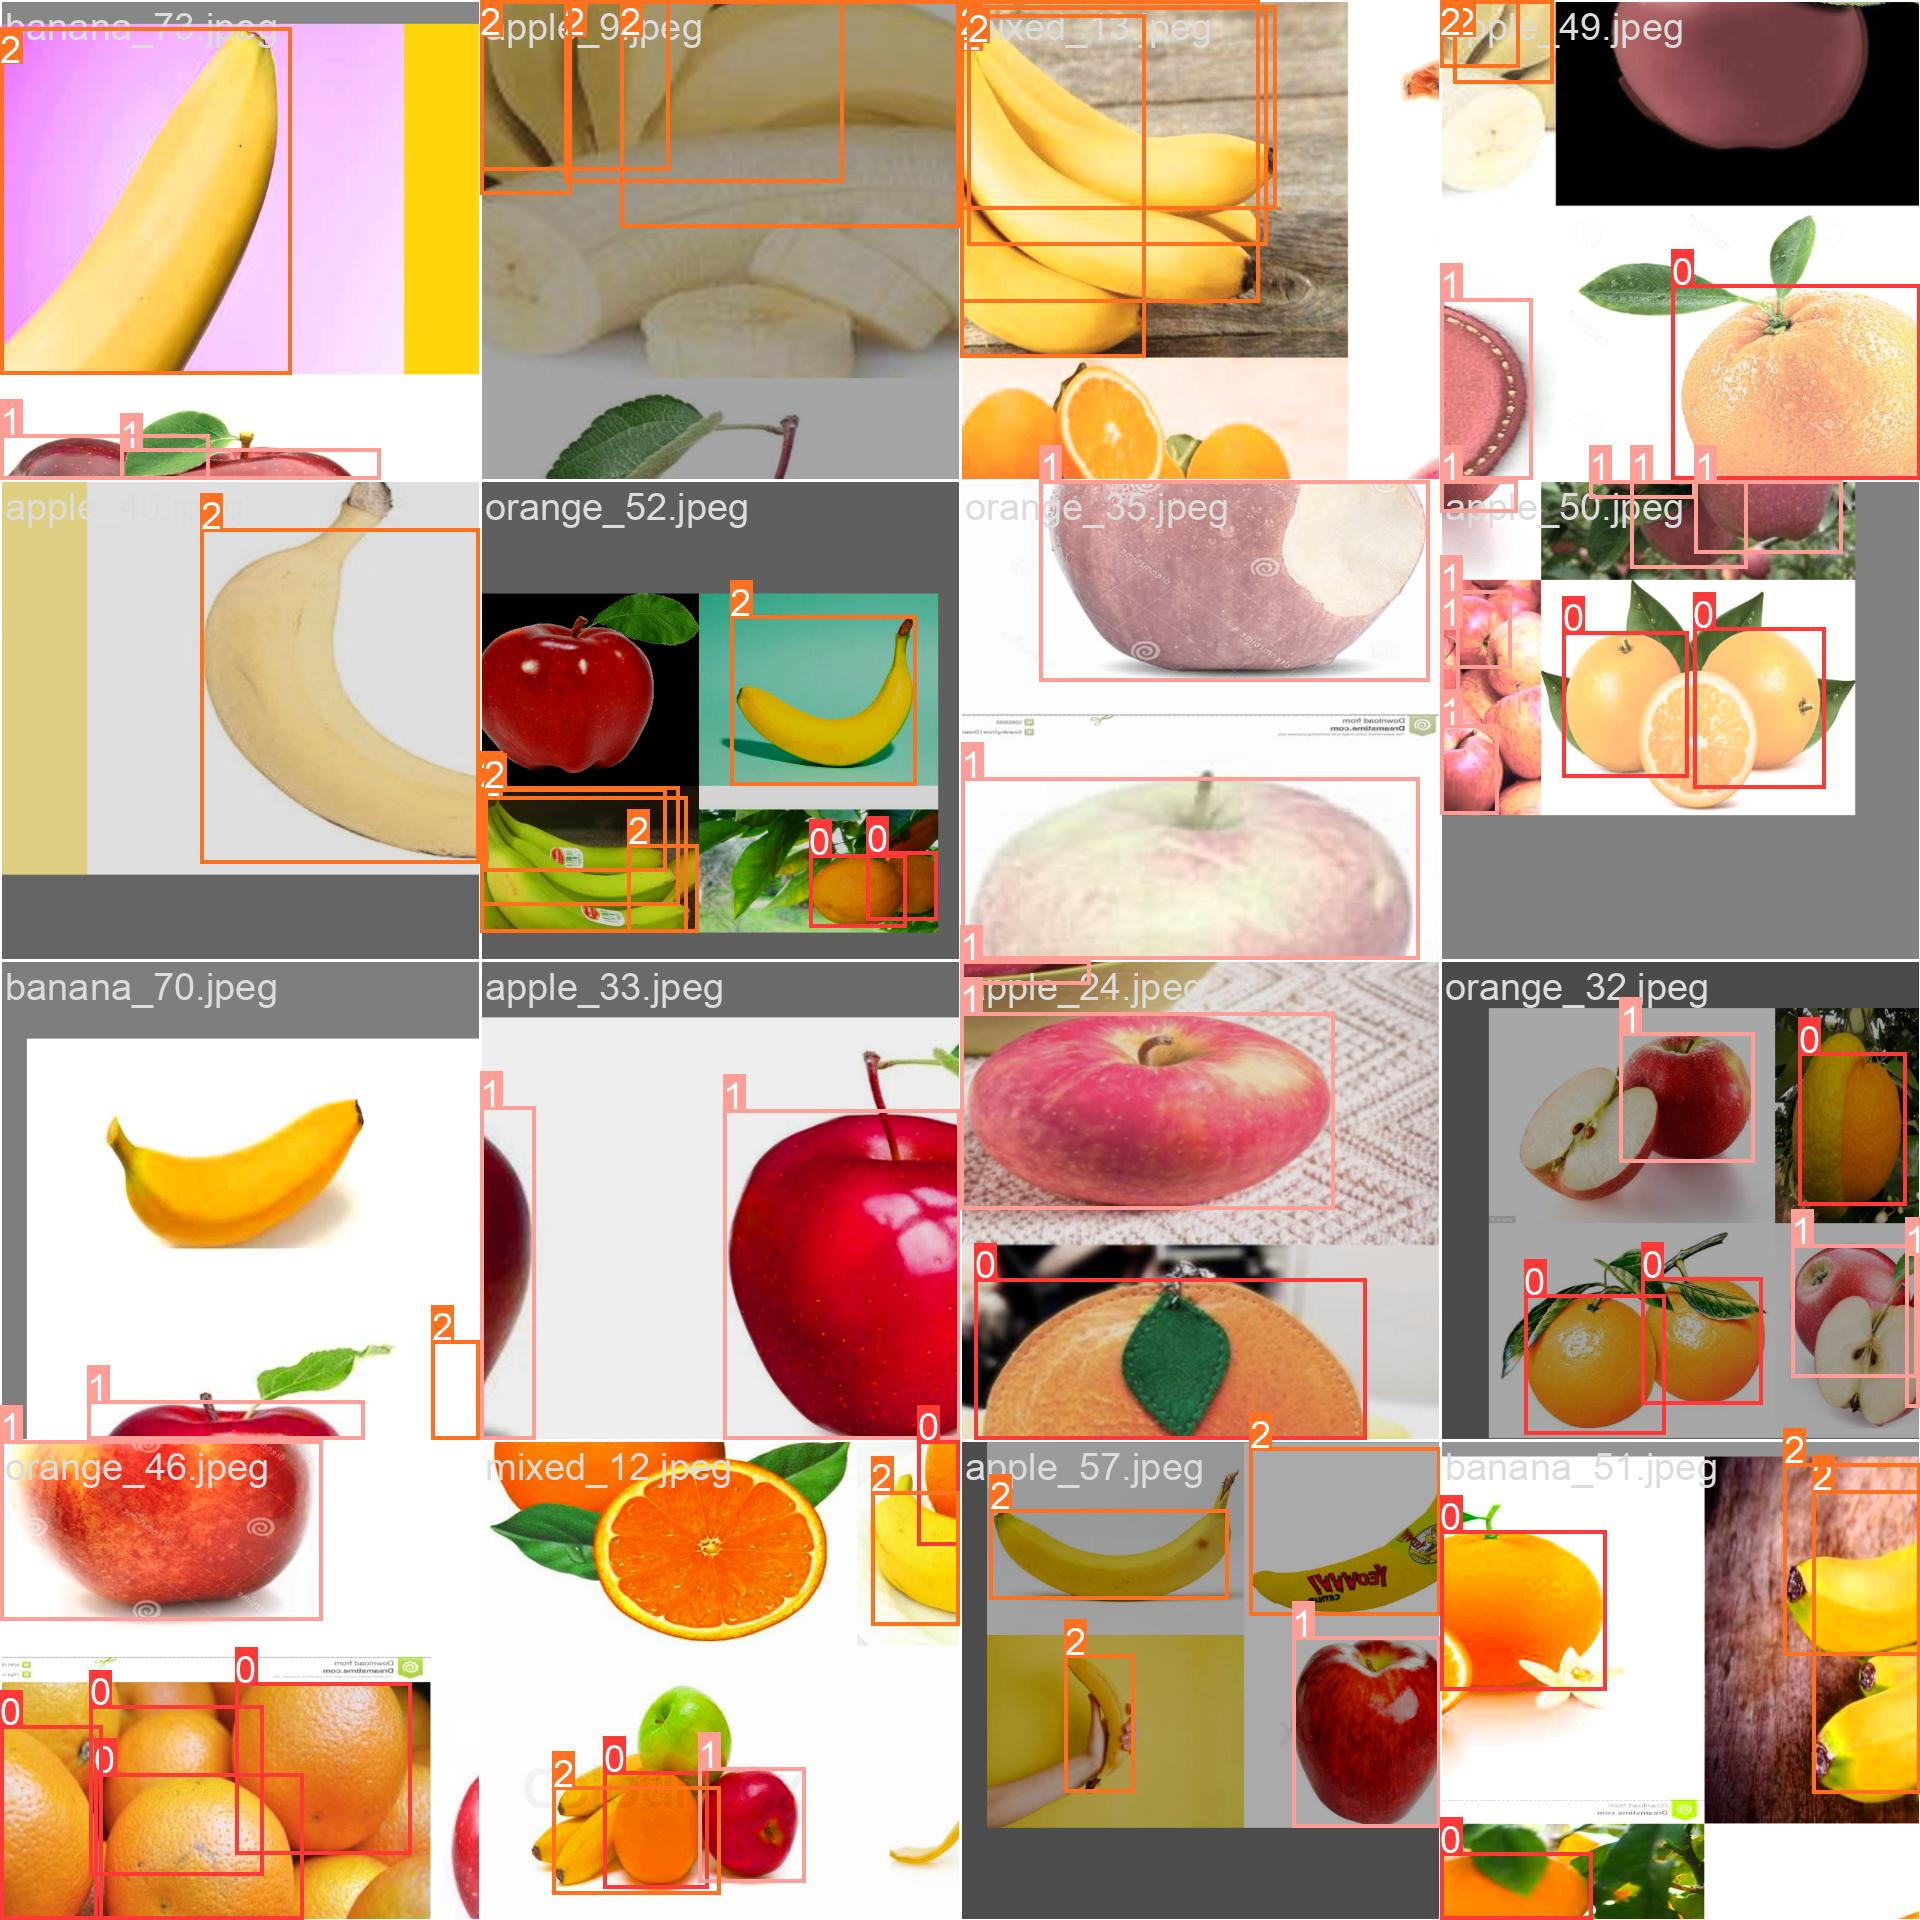

In [13]:
Display(filename='/content/drive/MyDrive/MASOOM_TSadiq/ML1/yolov5/runs/train/fruit_detection_yolov5/train_batch0.jpg', width=1000)


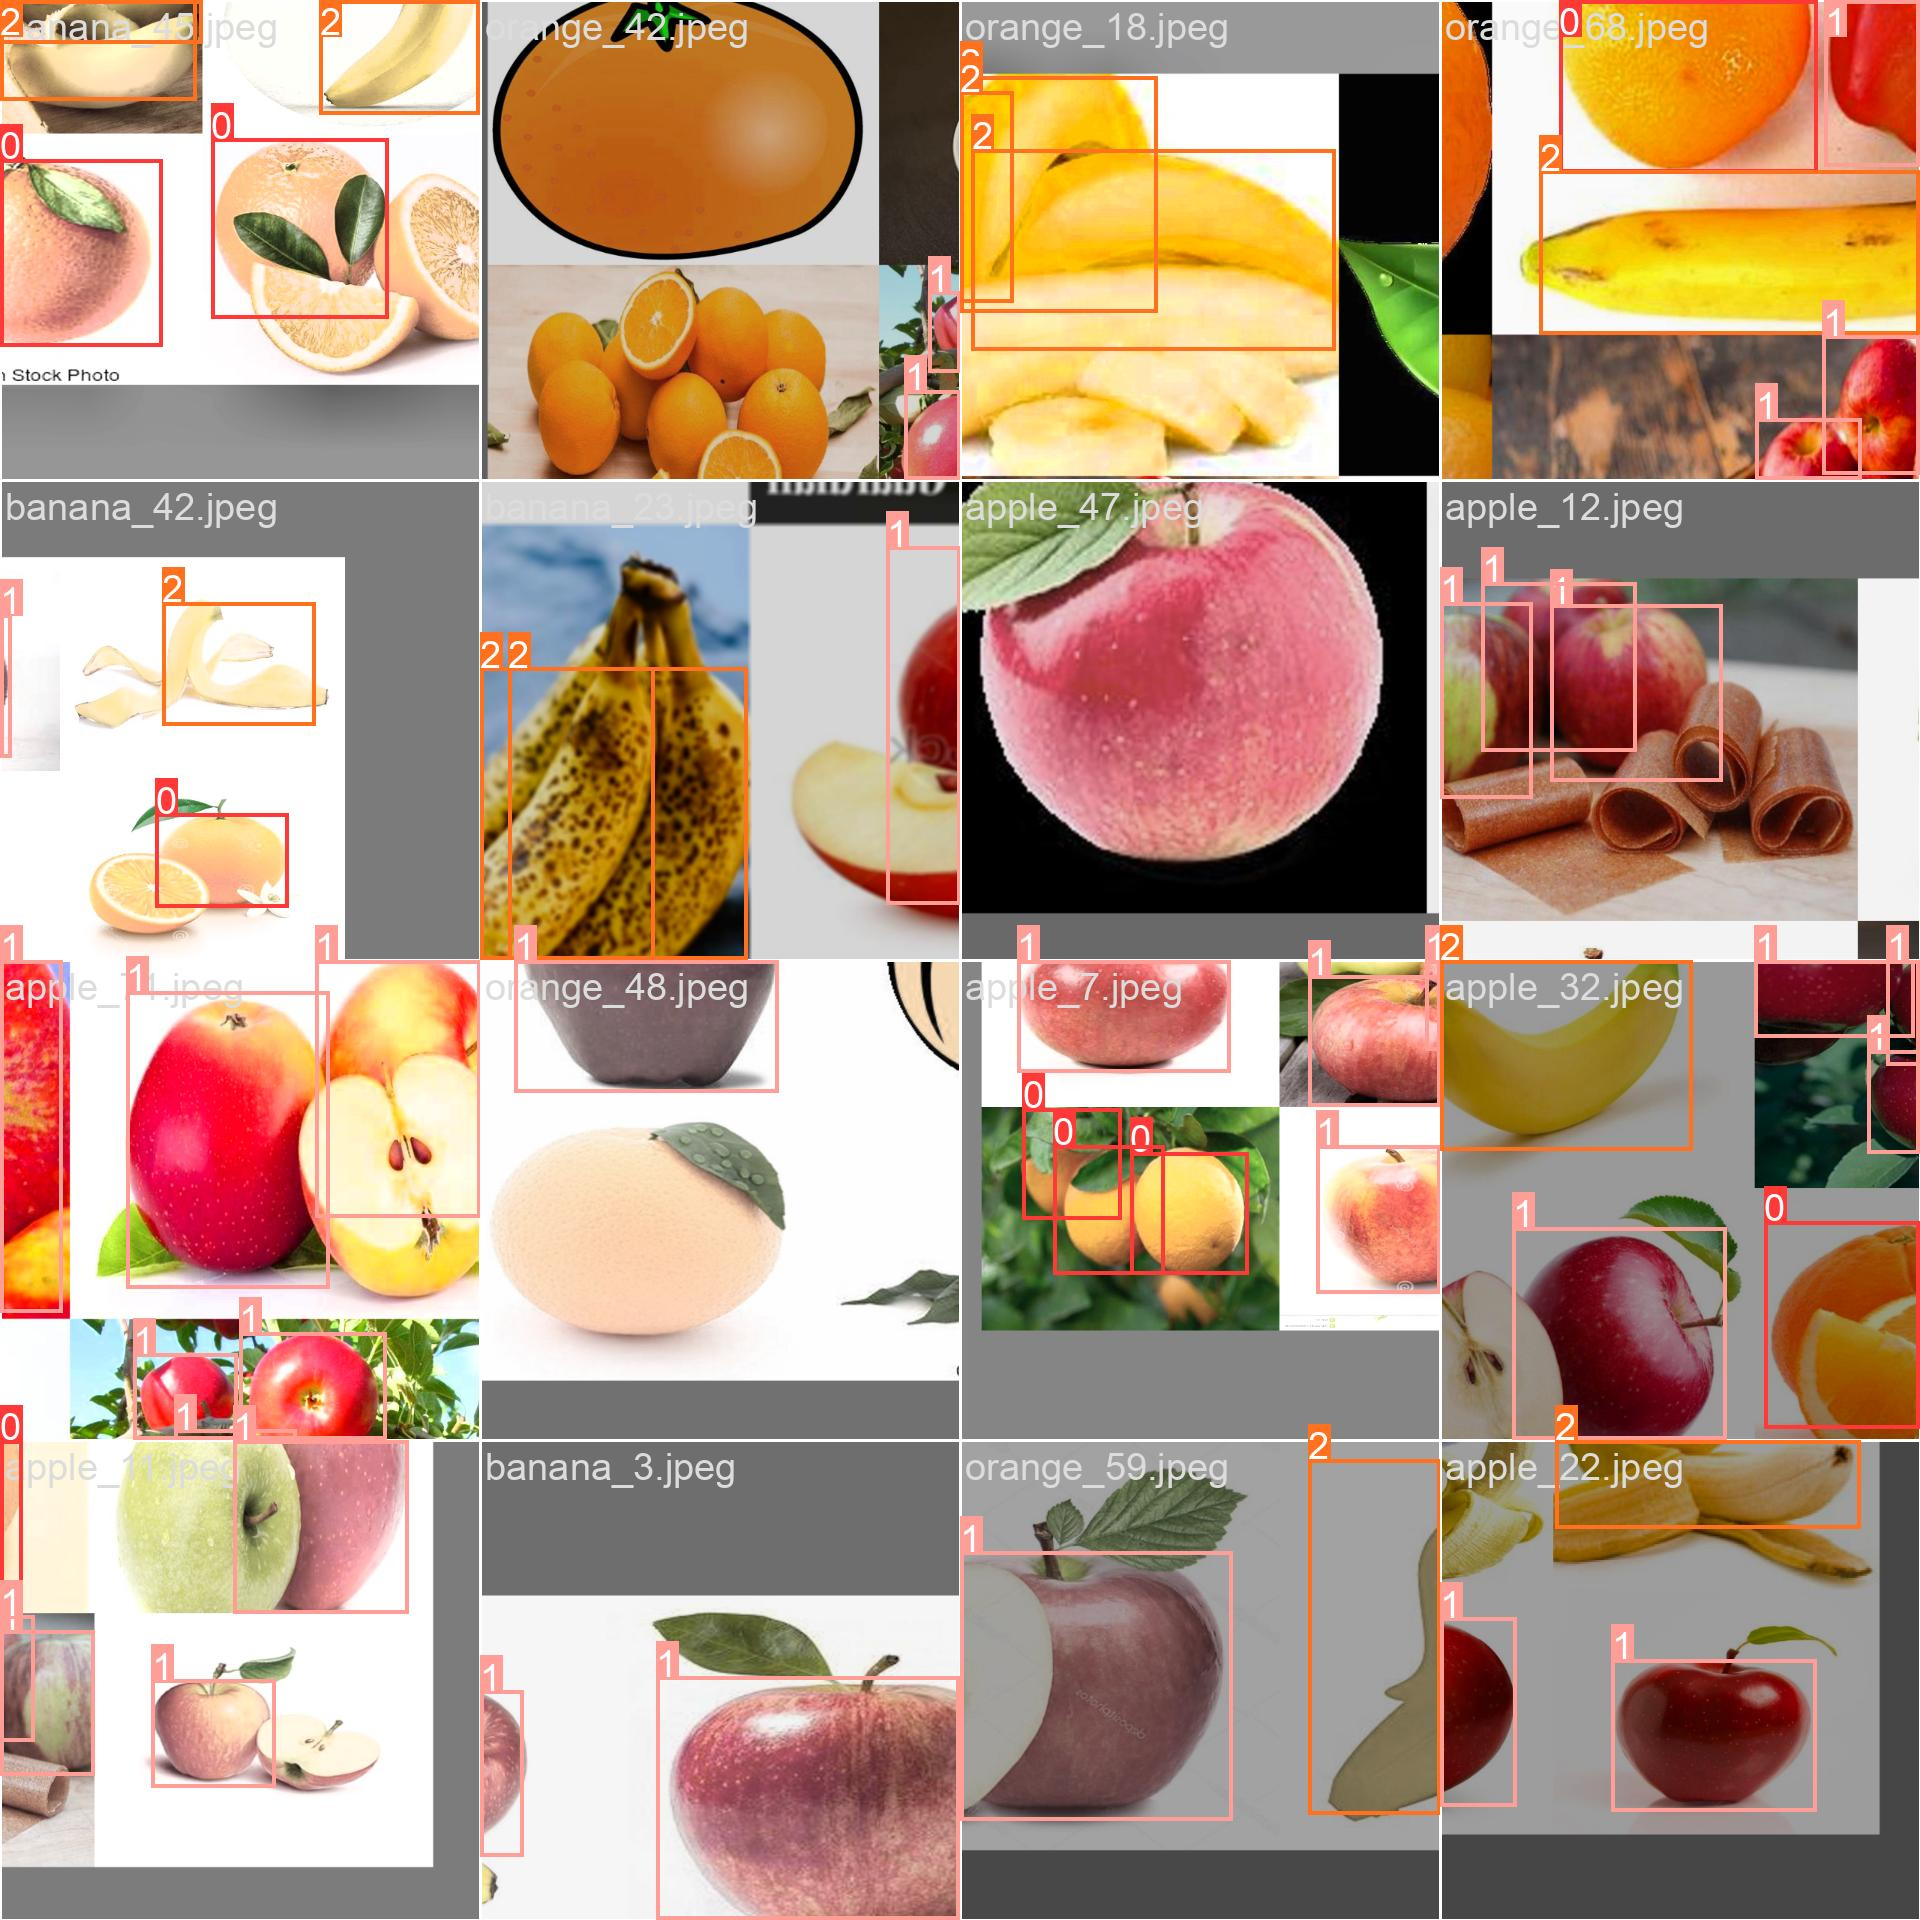

In [14]:
Display(filename='/content/drive/MyDrive/MASOOM_TSadiq/ML1/yolov5/runs/train/fruit_detection_yolov5/train_batch1.jpg', width=1000)

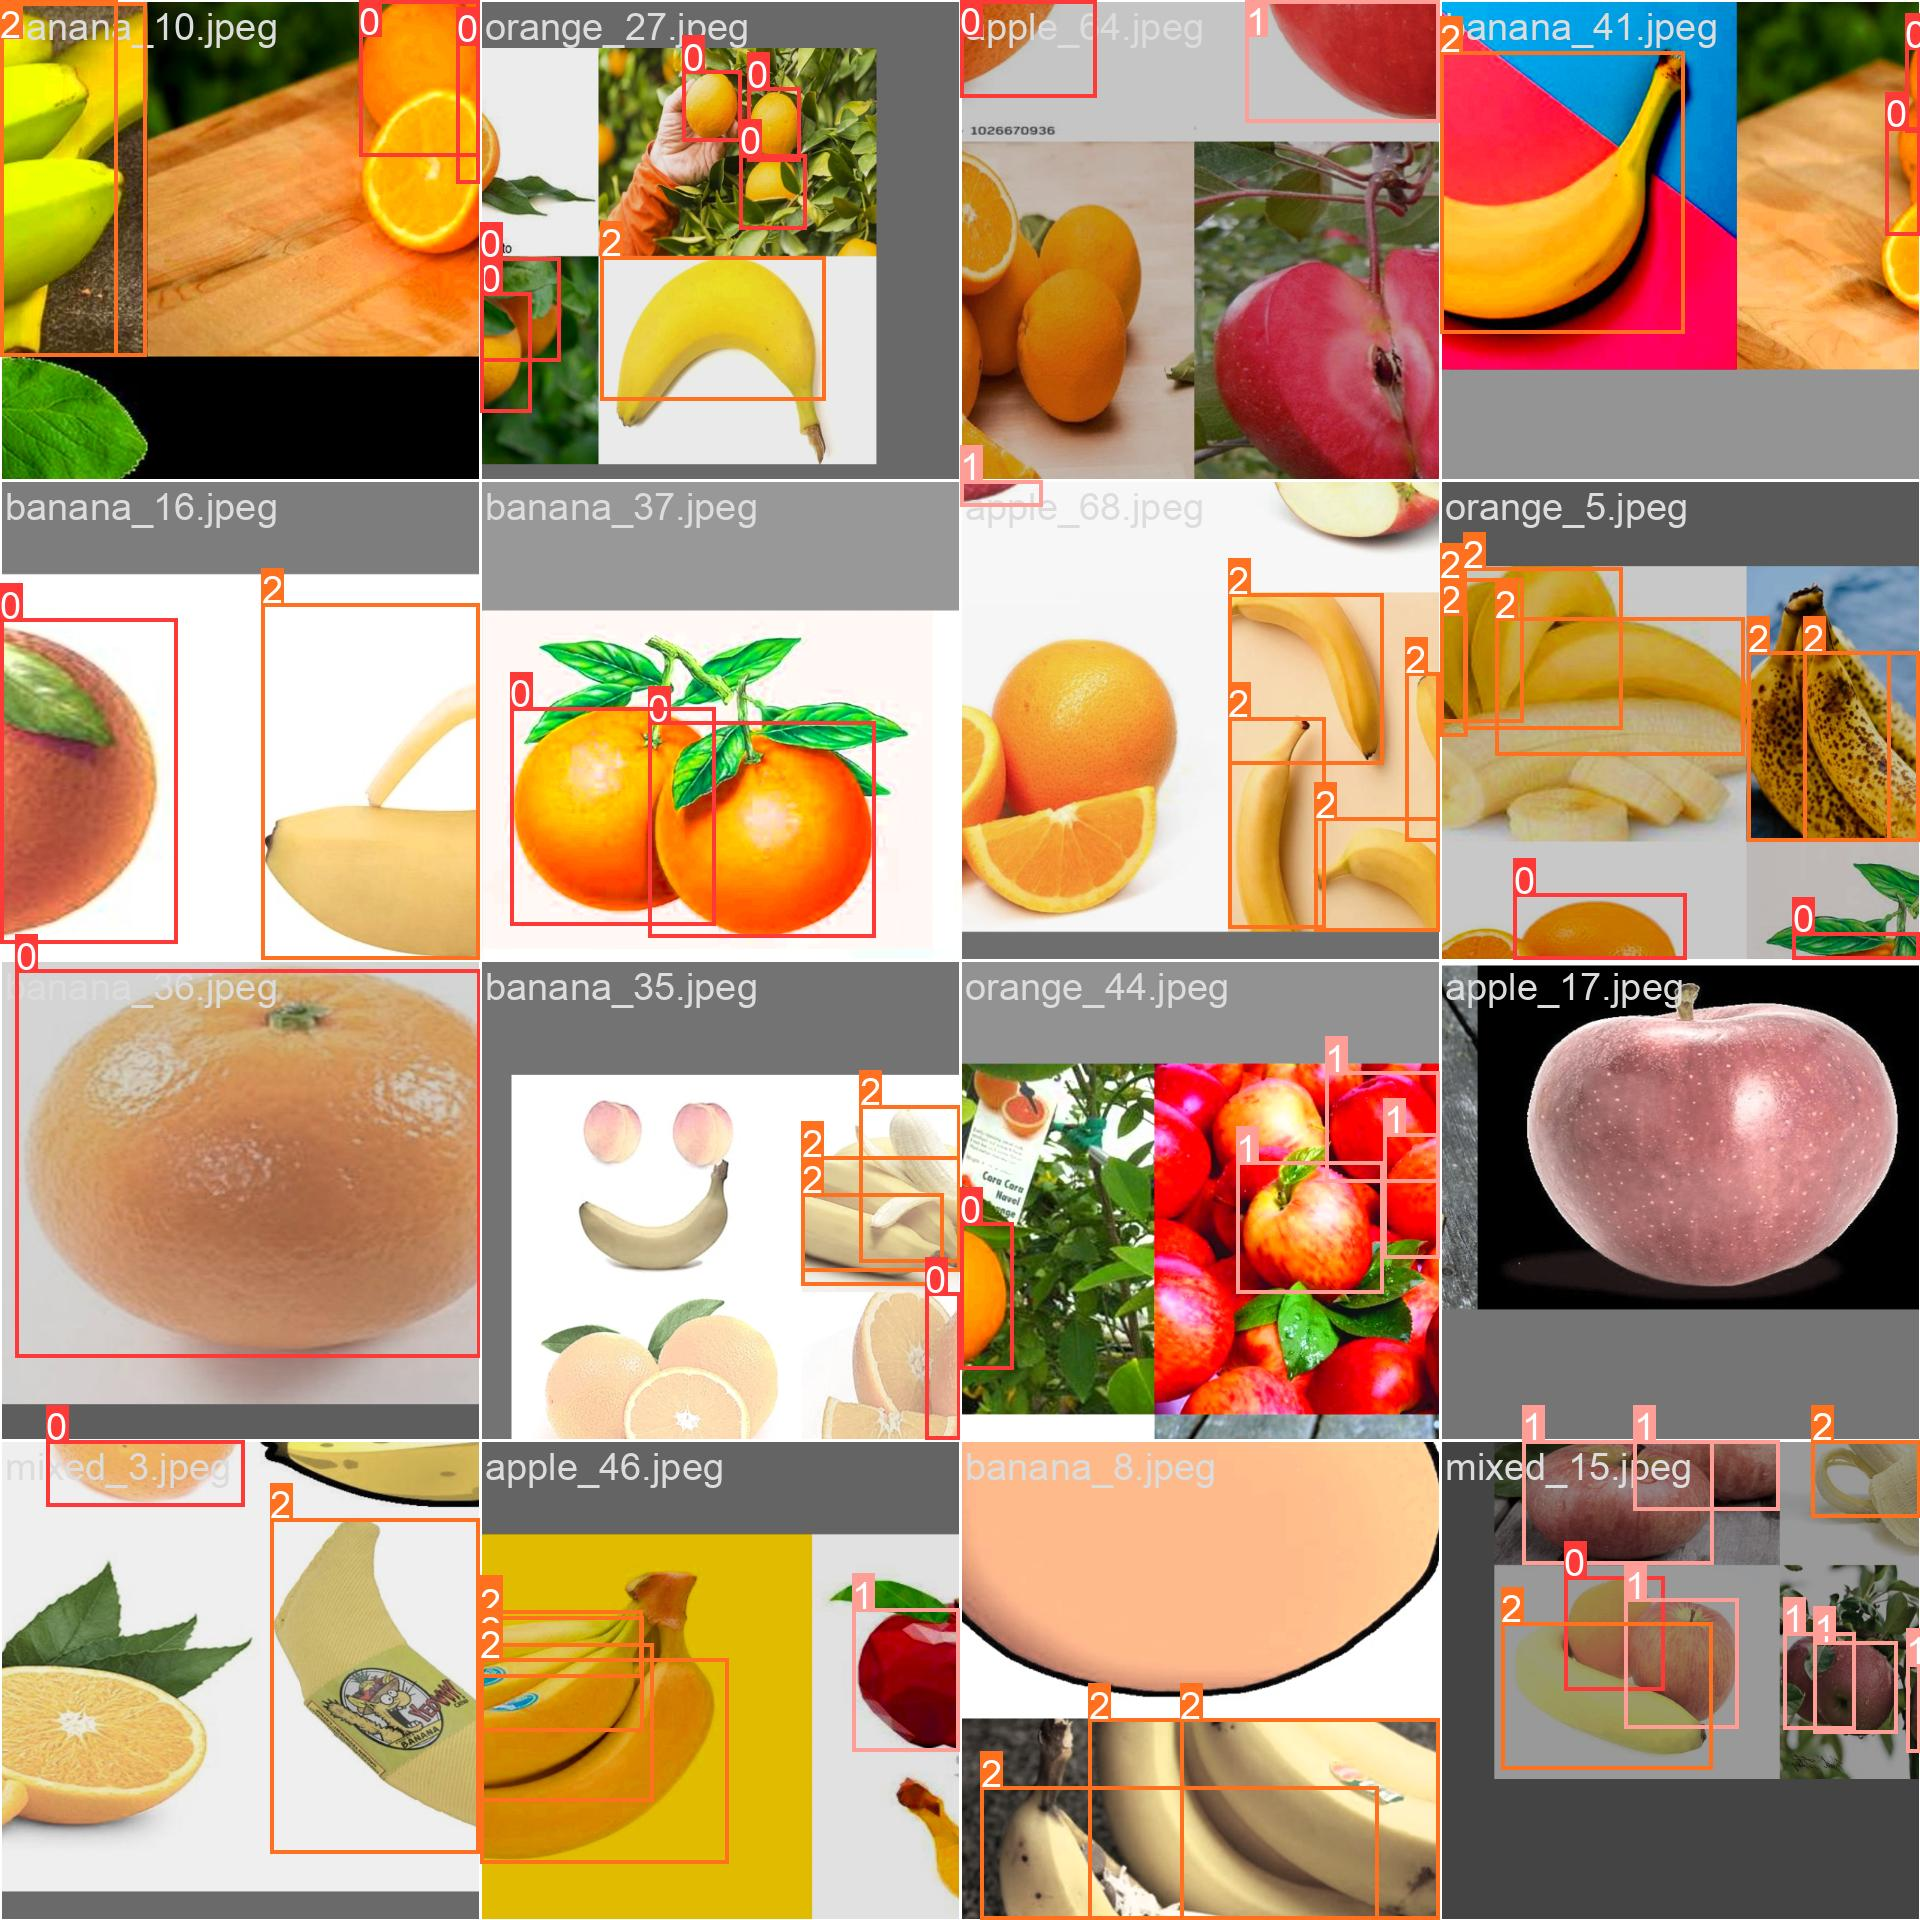

In [16]:

Display(filename='/content/drive/MyDrive/MASOOM_TSadiq/ML1/yolov5/runs/train/fruit_detection_yolov5/train_batch2.jpg', width=1000)

In [ ]:

def detect_realtime(weights, device, img_size=640, conf_thres=0.5, iou_thres=0.45):
    model = attempt_load(weights, map_location=device)
    imgsz = check_img_size(img_size, s=model.stride.max())
    if device.type != "cpu":
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))
    else:
        model(torch.zeros(1, 3, imgsz, imgsz))

    vid_cap = cv2.VideoCapture(0)

    while True:
        ret, frame = vid_cap.read()
        if not ret:
            break

        img = torch.from_numpy(frame).to(device)
        img = img.float() / 255.0
        img = img.permute(2, 0, 1).unsqueeze(0)

        pred = model(img)[0]
        pred = non_max_suppression(pred, conf_thres, iou_thres)[0]

        if pred is not None and len(pred):
            pred[:, :4] = scale_coords(img.shape[2:], pred[:, :4], frame.shape).round()
            for det in pred:
                xyxy = det[:4].cpu().numpy()
                conf = det[4].cpu().numpy()
                label = int(det[5].cpu().numpy())

                plot_one_box(xyxy, frame, label=f"{label}", color=[0, 255, 0], line_thickness=2)

        cv2.imshow("YOLOv5 Real-Time Detection", frame)
        if cv2.waitKey(1) == 27:
            break

    vid_cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    weights_path = "yolov5s.pt"  # Change this to the path of your YOLOv5 model weights
    device = select_device("")  # Leave empty for default device (GPU if available)
    detect_realtime(weights_path, device)

# matrix and F1 Score

In [ ]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1: List or array containing [xmin, ymin, xmax, ymax] of the first box.
        box2: List or array containing [xmin, ymin, xmax, ymax] of the second box.

    Returns:
        IoU: Intersection over Union value.
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    # Calculate intersection area
    x_intersection = max(0, min(x2, x4) - max(x1, x3))
    y_intersection = max(0, min(y2, y4) - max(y1, y3))
    intersection_area = x_intersection * y_intersection

    # Calculate areas of both bounding boxes
    area_box1 = (x2 - x1) * (y2 - y1)
    area_box2 = (x4 - x3) * (y4 - y3)

    # Calculate IoU
    IoU = intersection_area / float(area_box1 + area_box2 - intersection_area)
    return IoU

def calculate_metrics(gt_labels, gt_boxes, pred_labels, pred_boxes, confidence_threshold=0.5, iou_threshold=0.5):
    """
    Calculate precision, recall, and F1 score for object detection.

    Args:
        gt_labels: List of ground truth labels for each ground truth bounding box.
        gt_boxes: List of ground truth bounding boxes in the format [xmin, ymin, xmax, ymax].
        pred_labels: List of predicted labels for each predicted bounding box.
        pred_boxes: List of predicted bounding boxes in the format [xmin, ymin, xmax, ymax].
        confidence_threshold: Confidence threshold for predicted boxes (default is 0.5).
        iou_threshold: IoU threshold for matching predicted and ground truth boxes (default is 0.5).

    Returns:
        precision: Precision score.
        recall: Recall score.
        f1_score: F1 score.
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for pred_label, pred_box in zip(pred_labels, pred_boxes):
        pred_confidence = pred_box[-1]

        if pred_confidence < confidence_threshold:
            continue

        matched = False

        for gt_label, gt_box in zip(gt_labels, gt_boxes):
            iou = calculate_iou(pred_box[:-1], gt_box)

            if iou >= iou_threshold and pred_label == gt_label:
                true_positives += 1
                matched = True
                break

        if not matched:
            false_positives += 1

    false_negatives = len(gt_labels) - true_positives

    precision = true_positives / max(1, (true_positives + false_positives))
    recall = true_positives / max(1, (true_positives + false_negatives))
    f1_score = 2 * (precision * recall) / max(1e-9, (precision + recall))

    return precision, recall, f1_score

# Example usage:
gt_labels = ['apple', 'banana', 'orange']
gt_boxes = [[100, 100, 200, 200], [150, 150, 250, 250], [50, 50, 180, 180]]
pred_labels = ['apple', 'banana', 'orange']
pred_boxes = [[90, 90, 210, 210, 0.9], [160, 160, 240, 240, 0.85], [40, 40, 200, 200, 0.7]]

precision, recall, f1_score = calculate_metrics(gt_labels, gt_boxes, pred_labels, pred_boxes)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
